# Standalone Convergence Checker for the numerical vKdV solver tanh bottom

Here we introduce a bottom slope to the vKdV. We keep the IMEX without a flat bottom for comparison, but clearly no longer expect the same result. 

We also extend the domain for logistical reasons and run for longer. This requires a lower amplitude also or it just keeps steepening and crashes. 

### Bottom conditions
- Hyperbolic tangent starting from the same depth as the IMEX and runnint to half this
- At least one and a half wavelengths in the deeper section required (~100 km)
- Slope must be at 2 wavelengths (~120 km)
- At least one offshore wavelength in the shallower section

### Conclusions:
- 

In [1]:
import xarray as xr
from iwaves.kdv.kdvimex import KdVImEx#from_netcdf
from iwaves.kdv.vkdv import vKdV 
from iwaves.kdv.solve import solve_kdv
from iwaves.utils.plot import vKdV_plot
import iwaves.utils.initial_conditions as ics

import numpy as np
from scipy.interpolate import PchipInterpolator as pchip
import matplotlib.pyplot as plt

%matplotlib inline

from matplotlib import rcParams

# Set font sizes
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

# CONSTANTS FOR WHOLE NOTEBOOK
d = 252.5
L_d = 6.0e5
Nz = 100
bathy_params = [L_d/2, 60000, d, d/2]       
runtime = 4*86400.
a0 = 20.


In [28]:

# Functions

def run_kdv(args):
    """
    Main function for generating different soliton scenarios
    """
    rho_params, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw, solver = args
    ####################################################
    # Inputs
    mode = 0
    
    Nz = 100

    ntout = 1800.0

    z = np.linspace(0, -d, Nz)

    dz = np.abs(z[1]-z[0])
    
    x = np.arange(-2*dx,L_d+dx,dx)
        
    if solver == 'vkdv':
#         h = 0*x+d
        h = ics.depth_tanh2(bathy_params, x) # CHANGED
    elif solver == 'imex':
        h = None

    kdvargs = dict(\
        verbose=False,\
        a0=a0,\
        Lw=Lw,\
        mode=mode,
        dt=dt,\
        nu_H=nu_H,\
        ekdv=False,\
        wavefunc=ics.eta_fullsine,\
        #L_d = L_d,
        x=x,\
        Nsubset=10,
    )

    ###
#     THIS WAS COPIED FROM THE KdV VERSION. IT INITIALISES EACH vKdV 3 TIMES - QUITE SLOW. 
    ###
    
    ii=0
    #rhoz = single_tanh_rho(
    #        z, pp['rho0'][ii], pp['drho1'][ii], pp['z1'][ii], pp['h1'][ii])
    rhoz = ics.rho_double_tanh_rayson(rho_params,z)
    ######

    ## Call the vKdV run function
    mykdv, Bda = solve_kdv(rhoz, z, runtime,\
            solver=solver, h=h, ntout=ntout, outfile=None, **kdvargs)

    print('Done with dx={} and dt={}'.format(dx, dt))
    
    return mykdv, Bda

In [30]:
#betas = [1023.7, 1.12, 105, 52, 155, 43] # ~April 5
#betas = [1023.5, 1.22, 67, 55, 157, 52] # ~March 1

betas_w = [1023.8229810318612,
     0.9865506702797462,
     143.5428700089361,
     46.1265812512485,
     136.66278860120943,
     41.57014327398592] # 15 July 2016

betas_s =[1023.6834358117951,
     1.2249066117658955,
     156.78804559089772,
     53.66835548728355,
     73.14183287436342,
     40.21031777315428] # 1st April 2017

mode =0
nu_H = 0

# Going to make Lw an input for the vKdV as it will really speed things up. 
dx = 100
dt = 10

z = np.linspace(0, -d, Nz)
rhoz_w = ics.rho_double_tanh_rayson(betas_w, z)
rhoz_s = ics.rho_double_tanh_rayson(betas_s, z)
Lw_w = ics.get_Lw(rhoz_w, z, z0=max(h), mode=0)
Lw_s = ics.get_Lw(rhoz_s, z, z0=max(h), mode=0)

print(Lw_w)
print(Lw_s)

57422.31285049348
56099.67477541894


In [58]:
dxs =[1600,800,400,200,100,75,50,37.5,25]
dxs =[800,200,100,50]
dt = 8.

all_vkdv_dx_w = []
all_vkdv_dx_s = []

all_kdvimex_dx_w = []
all_kdvimex_dx_s = []

for dx in dxs:
    
    print(' ')
    print('Running dx={}'.format(dx))
    print(' ')
    
    mykdv, B = run_kdv( (betas_w, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_w, 'imex'))
    all_kdvimex_dx_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_w, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_w, 'vkdv'))
    all_vkdv_dx_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'imex'))
    all_kdvimex_dx_s.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'vkdv'))
    all_vkdv_dx_s.append(mykdv)
    
    print(' ')
    print('Completed dx={}'.format(dx))
    print(' ')

 
Running dx=800
 
Done with dx=800 and dt=8.0
Calculating eigenfunctions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=800 and dt=8.0
Done with dx=800 and dt=8.0
Calculating eigenfunctions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
50.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=800 and dt=8.0
 
Completed dx=800
 
 
Running dx=200
 
Done with dx=200 and dt=8.0
Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete..

# Just double check that vKdV used the correct bathy

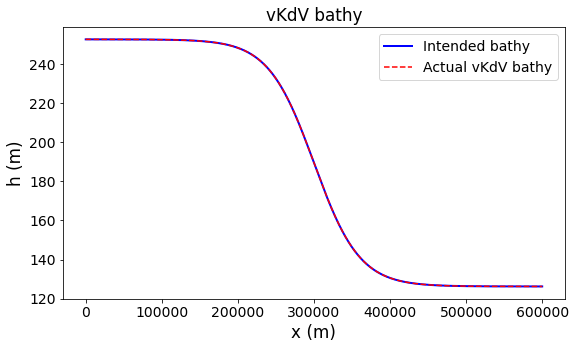

In [59]:
dx = 10
x = np.arange(-2*dx,L_d+dx,dx)

# h = 0*x+d
h = ics.depth_tanh2(bathy_params, x)
    
plt.figure(figsize=(9,5))
plt.plot(x, h, 'b', label='Intended bathy', linewidth=2)
plt.plot(all_vkdv_dx_w[-1].x, all_vkdv_dx_w[-1].h, 'r--', label='Actual vKdV bathy')
plt.ylabel('h (m)')
plt.xlabel('x (m)')
plt.title('vKdV bathy')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Summer vKdV zoom')

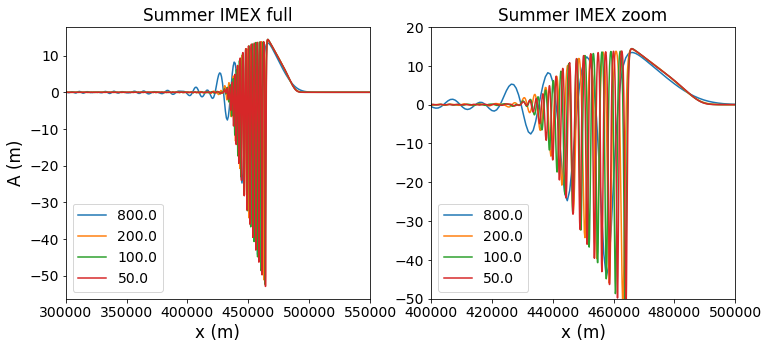

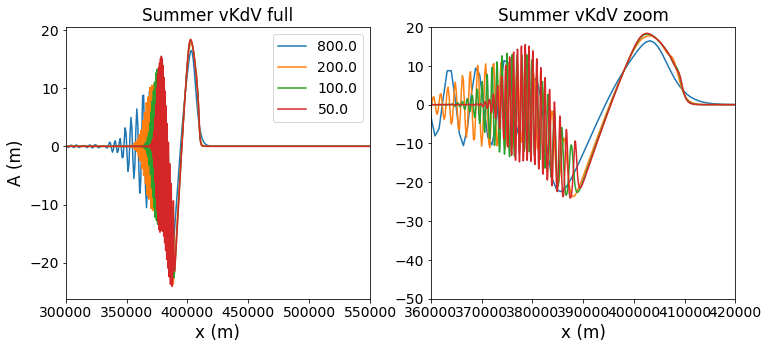

In [60]:

full_lims = (300000, 550000)
zoom_lims_imex   = (420000, 480000)
zoom_lims_vkdv   = (360000, 420000)
zoom_lims_y = (-50, 20)

###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer IMEX full')
plt.legend()

ax=plt.subplot(122)
for mykdv in all_kdvimex_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
# plt.xlim((162200, 163600))
plt.ylim(zoom_lims_y)
plt.xlim(zoom_lims)
plt.legend()
plt.xlabel('x (m)')
plt.title('Summer IMEX zoom')


###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer vKdV full')
plt.legend()

ax=plt.subplot(122)
for mykdv in all_vkdv_dx_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim((100000, 500000))
plt.ylim(zoom_lims_y)
plt.xlim(zoom_lims_vkdv)
plt.xlabel('x (m)')
plt.title('Summer vKdV zoom')


Text(0.5, 1.0, 'Winter vKdV zoom')

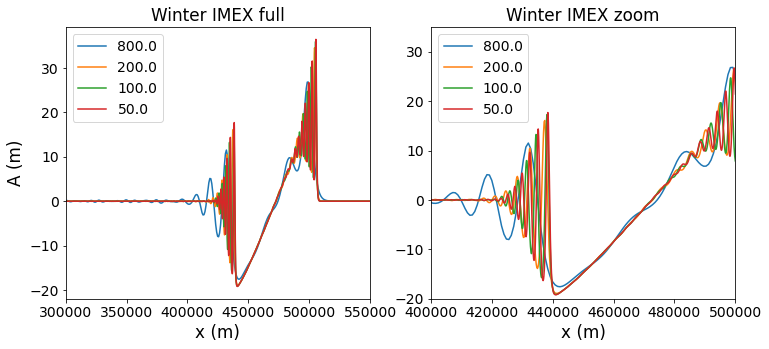

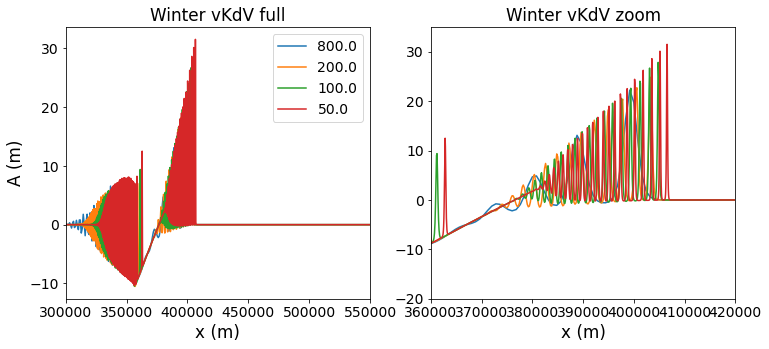

In [61]:
zoom_lims_imex   = (400000, 500000)
zoom_lims_vkdv   = (360000, 420000)
zoom_lims_y = (-20, 35)

###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dx_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Winter IMEX full')
plt.legend()

ax=plt.subplot(122)
for mykdv in all_kdvimex_dx_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
# plt.xlim((162200, 163600))
plt.ylim(zoom_lims_y)
plt.xlim(zoom_lims_imex)
plt.legend()
plt.xlabel('x (m)')
plt.title('Winter IMEX zoom')


###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dx_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
plt.xlim(full_lims)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Winter vKdV full')
plt.legend()

ax=plt.subplot(122)
for mykdv in all_vkdv_dx_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dx_s)
# plt.xlim((162200, 163600))
plt.ylim(zoom_lims_y)
plt.xlim(zoom_lims_vkdv)
plt.xlabel('x (m)')
plt.title('Winter vKdV zoom')


In [73]:
# Compute the errors
X = np.arange(0,L_d, 10.)
nx = X.shape[0]
ndx = len(dxs)

def get_rms_error(mykdv, nd):
    
    solns = np.zeros((nd, nx))
    for ii, mykdv in enumerate(mykdv):
        Fx = pchip(mykdv.x, mykdv.B)
        solns[ii,:] = Fx(X)

    # Compute the error between each solution
    #err = np.diff(solns, axis=0)
    err = solns - solns[-1,:]

    err_rms = np.linalg.norm(err, ord=2, axis=1) # L2-norm
    #err_rms_w = np.sqrt(np.mean(err**2,axis=1))

    return err_rms

err_rms_vkdv_w = get_rms_error(all_vkdv_dx_w, ndx)
err_rms_vkdv_s = get_rms_error(all_vkdv_dx_s, ndx)

err_rms_kdvimex_w = get_rms_error(all_kdvimex_dx_w, ndx)
err_rms_kdvimex_s = get_rms_error(all_kdvimex_dx_s, ndx)


<class 'numpy.float64'>
<class 'numpy.ndarray'>


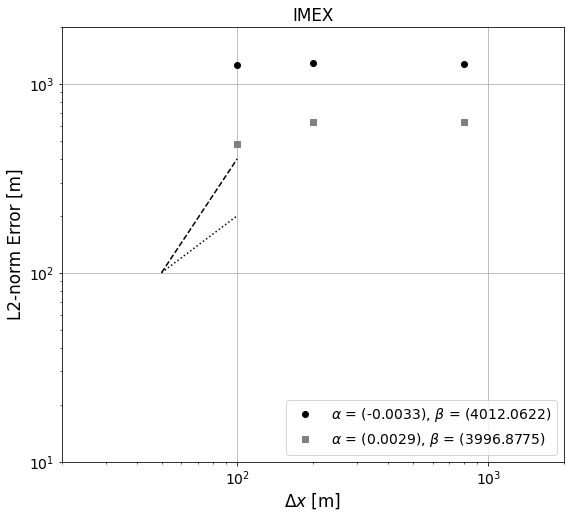

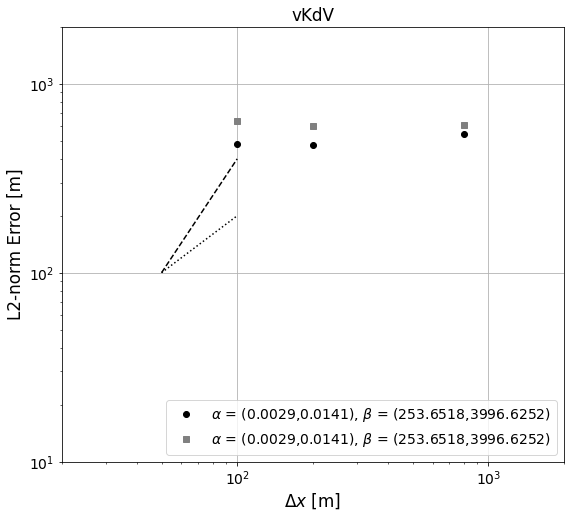

In [63]:

def make_dx_convergence_plot(kdv_s, kdv_w, err_s, err_w, tit):
    
    plt.figure(figsize=(9,8))
    plt.loglog(dxs[:-1],err_s[:-1],'ko')
    plt.loglog(dxs[:-1],err_w[:-1],'s', color='0.5')
    plt.xlim(2e1,2e3)
    plt.ylim(1e1,2e3)
    plt.grid(b=True)
    x0 = np.array([50,100.])
    plt.plot(x0, 100/x0[0]**2*x0**2, 'k--')
    plt.plot(x0, 100/x0[0]**1*x0**1, 'k:')
    plt.ylabel('L2-norm Error [m]')
    plt.xlabel('$\Delta x$ [m]')
    plt.title(tit)
    
    alpha_s = -2*kdv_s[0].c1*kdv_s[0].r10 
    beta_s = -1*kdv_s[0].r01
    alpha_w = -2*kdv_w[0].c1*kdv_w[0].r10 
    beta_w = -1*kdv_w[0].r01
    
    print(type(alpha_s)) 
    
    if not type(alpha_s) == np.float64:

        plt.legend((r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.4f,%3.4f)'%(min(alpha_s), max(alpha_s), min(beta_s), max(beta_s)),
                   r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.4f,%3.4f)'%(min(alpha_w), max(alpha_w), min(beta_w), max(beta_w))), loc='lower right')
    else:
        
        plt.legend((r'$\alpha$ = (%3.4f), $\beta$ = (%3.4f)'%(alpha_s, beta_s),
                   r'$\alpha$ = (%3.4f), $\beta$ = (%3.4f)'%(alpha_w, beta_w)), loc='lower right')
    
make_dx_convergence_plot(all_kdvimex_dx_s, all_kdvimex_dx_w, err_rms_kdvimex_s, err_rms_kdvimex_w, 'IMEX')
make_dx_convergence_plot(all_vkdv_dx_w, all_vkdv_dx_w, err_rms_vkdv_s, err_rms_vkdv_w, 'vKdV')


In [64]:
# Delta t comparison
dts = [20,10.,5,2.5,1.25,0.6,0.3]
dx = 50.

all_vkdv_dt_w = []
all_vkdv_dt_s = []

all_kdvimex_dt_w = []
all_kdvimex_dt_s = []

for dt in dts:
    
    print(' ')
    print('Running dt={}'.format(dt))
    print(' ')
    
    mykdv, B = run_kdv( (betas_w, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_w, 'imex'))
    all_kdvimex_dt_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'imex'))
    all_kdvimex_dt_s.append(mykdv)
    
    
    mykdv, B = run_kdv( (betas_w, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_w, 'vkdv'))
    all_vkdv_dt_w.append(mykdv)
    
    mykdv, B = run_kdv( (betas_s, bathy_params, a0, L_d, mode, nu_H, dx, runtime, dt, Lw_s, 'vkdv'))
    all_vkdv_dt_s.append(mykdv)
    
    
    print(' ')
    print('Completed dt={}'.format(dt))
    print(' ')
    

 
Running dt=20
 
Done with dx=50.0 and dt=20
Done with dx=50.0 and dt=20
Calculating eigenfunctions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...
100.0 % complete...
Calculating nonlinear structure functions...
0.0 % complete...
5.0 % complete...
10.0 % complete...
15.0 % complete...
20.0 % complete...
25.0 % complete...
30.0 % complete...
35.0 % complete...
40.0 % complete...
45.0 % complete...
50.0 % complete...
55.0 % complete...
60.0 % complete...
65.0 % complete...
70.0 % complete...
75.0 % complete...
80.0 % complete...
85.0 % complete...
90.0 % complete...
95.0 % complete...
100.0 % complete...
Calculating buoyancy coefficients...
Done with dx=50.0 

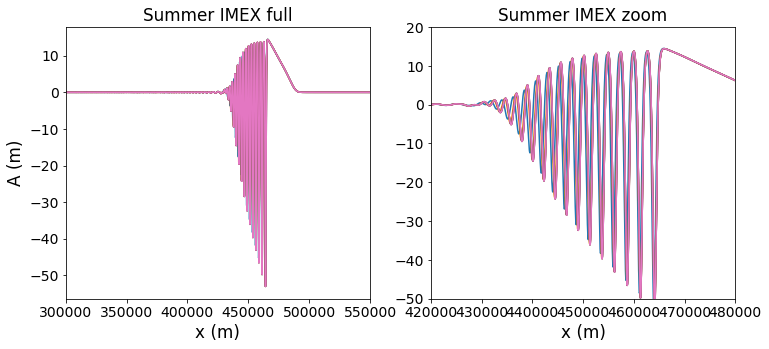

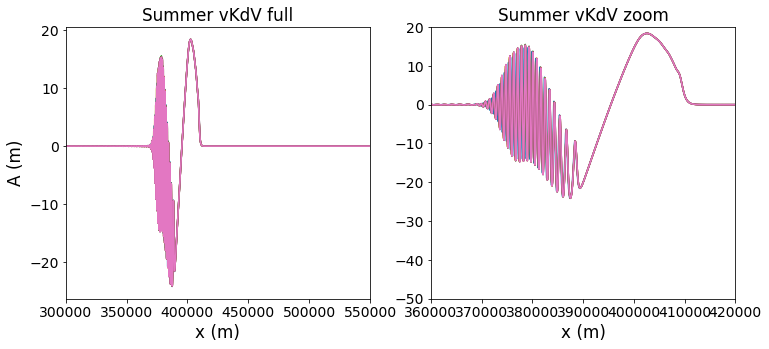

In [68]:

###########################
##### SUMMER

full_lims = (300000, 550000)
zoom_lims_imex   = (420000, 480000)
zoom_lims_vkdv   = (360000, 420000)
zoom_lims_y = (-50, 20)

###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer IMEX full')    
plt.xlim((full_lims))

ax=plt.subplot(122)
for mykdv in all_kdvimex_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_imex))
plt.xlabel('x (m)')
plt.title('Summer IMEX zoom')
plt.show()

###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer vKdV full')    
plt.xlim((full_lims))

ax=plt.subplot(122)
for mykdv in all_vkdv_dt_s:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_vkdv))
plt.xlabel('x (m)')
plt.title('Summer vKdV zoom')
plt.show()


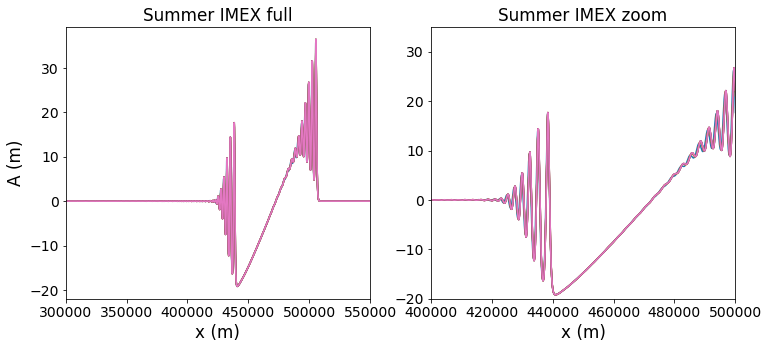

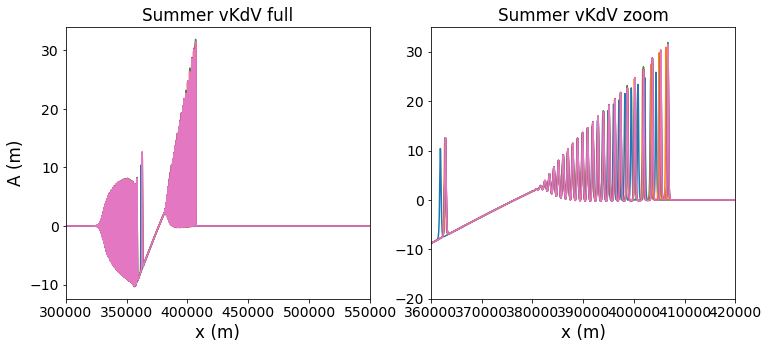

In [69]:

###########################
##### WINTER
zoom_lims_imex   = (400000, 500000)
zoom_lims_vkdv   = (360000, 420000)
zoom_lims_y = (-20, 35)


###########################
##### IMEX
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_kdvimex_dt_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer IMEX full')    
plt.xlim((full_lims))

ax=plt.subplot(122)
for mykdv in all_kdvimex_dt_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_imex))
plt.xlabel('x (m)')
plt.title('Summer IMEX zoom')
plt.show()

###########################
##### vKdV
plt.figure(figsize=(12,5))
ax=plt.subplot(121)
for mykdv in all_vkdv_dt_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
plt.ylabel('A (m)')
plt.xlabel('x (m)')
plt.title('Summer vKdV full')    
plt.xlim((full_lims))

ax=plt.subplot(122)
for mykdv in all_vkdv_dt_w:
    plt.plot(mykdv.x, mykdv.B, label=mykdv.dt_s)
    
plt.ylim(zoom_lims_y)
plt.xlim((zoom_lims_vkdv))
plt.xlabel('x (m)')
plt.title('Summer vKdV zoom')
plt.show()


In [72]:
all_vkdv_dt_w

In [76]:
ndt = len(dts)

err_rms_vkdv_dt_w = get_rms_error(all_vkdv_dt_w, ndt)
err_rms_vkdv_dt_s = get_rms_error(all_vkdv_dt_s, ndt)

err_rms_kdvimex_dt_w = get_rms_error(all_kdvimex_dt_w, ndt)
err_rms_kdvimex_dt_s = get_rms_error(all_kdvimex_dt_s, ndt)


<ipython-input-78-eba99b39d950>:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.5e2)
<ipython-input-78-eba99b39d950>:6: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,0.5e2)


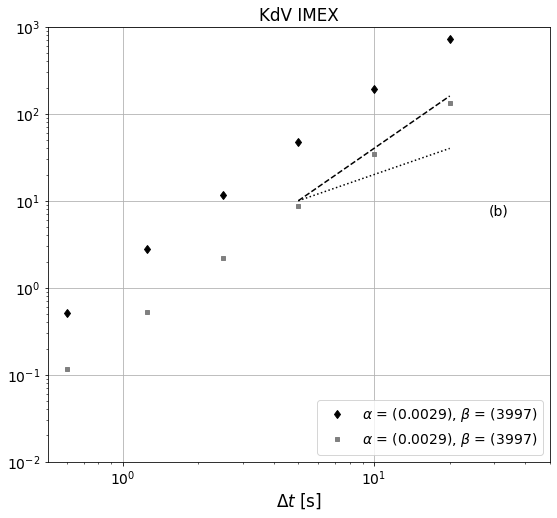

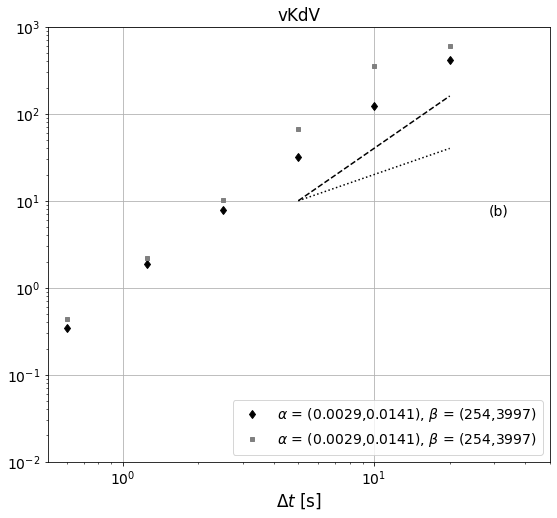

In [78]:

def make_dt_convergence_plot(kdv_s, kdv_w, err_s, err_w, tit):

    plt.figure(figsize=(9,8))
    plt.loglog(dts[:-1],err_s[:-1],'kd', markersize=6)
    plt.loglog(dts[:-1],err_w[:-1],'s', color='0.5', markersize=4)
    plt.xlim(0,0.5e2)
    plt.ylim(1e-2,1e3)
    plt.grid(b=True)
    x0 = np.array([5,20])
    plt.plot(x0, 10/x0[0]**2*x0**2, 'k--')
    plt.plot(x0, 10/x0[0]**1*x0**1, 'k:')
    #plt.ylabel('L2-norm Error [m]')
    plt.xlabel('$\Delta t$ [s]')
    plt.title(tit)
    
    plt.text(0.05,0.95,'(b)',transform=ax.transAxes)
    alpha_s = -2*kdv_s[0].c1*kdv_s[0].r10 
    beta_s = -1*kdv_s[0].r01
    alpha_w = -2*kdv_w[0].c1*kdv_w[0].r10 
    beta_w = -1*kdv_w[0].r01

    if not type(alpha_s) == np.float64:

        plt.legend((r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.0f,%3.0f)'%(min(alpha_s), max(alpha_s), min(beta_s), max(beta_s)),
                   r'$\alpha$ = (%3.4f,%3.4f), $\beta$ = (%3.0f,%3.0f)'%(min(alpha_w), max(alpha_w), min(beta_w), max(beta_w))), loc='lower right')
    else:
        
        plt.legend((r'$\alpha$ = (%3.4f), $\beta$ = (%3.0f)'%(alpha_s, beta_s),
                   r'$\alpha$ = (%3.4f), $\beta$ = (%3.0f)'%(alpha_w, beta_w)), loc='lower right')
        
    plt.savefig('../FIGURES/vkdv_convergence_dxdt.png',dpi=150)
    plt.savefig('../FIGURES/vkdv_convergence_dxdt.pdf',dpi=150)
    
make_dt_convergence_plot(all_kdvimex_dt_w, all_kdvimex_dt_w, err_rms_kdvimex_dt_s, err_rms_kdvimex_dt_w, 'KdV IMEX')
make_dt_convergence_plot(all_vkdv_dt_w, all_vkdv_dt_w, err_rms_vkdv_dt_s, err_rms_vkdv_dt_w, 'vKdV')
